# Model Training

### Data and packages import

In [2]:
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer,StandardScaler # with_std=False to center around the mean only
plt.style.use('bmh')
from scipy import stats

In [3]:
df = pd.read_csv('data\germany-wind-energy.csv')

Using the data presented in EDA notebooks, we model this time series with two approaches:

- Autoregressive model 
- Autoregressive model with explanatory variables

# 1. AR approach

As transformation, we use the square root and then we center the values:

In [4]:
z = df['wind_generation_actual'].values

square_root = FunctionTransformer(np.sqrt) 

z = square_root.transform(z)

In [5]:
scaler = StandardScaler(with_std=False) # this function center the values around the mean
scaler_f = scaler.fit(z.reshape(-1, 1))
z = scaler_f.transform(z.reshape(-1,1))

Now we need an evaluation function for obtaining some metrics after training

In [6]:
def evaluate_model(true, predicted):
    abs_rmse = mean_squared_error(true, predicted,squared = False)
    rel_rmse = abs_rmse/(np.max(z)-np.min(z))

    return np.round(abs_rmse,4), np.round(rel_rmse,4)


To split train and test data, we use the time series excluding the last 10 observations for training, then the forecast will be done for these 10 days considereing them as "test" set

In [7]:
train_data = z[:-10]
test_data = z[-10:]

As shown in PACF plot, we fit a AR(3) model using the function SARIMA which is more general and can be replicated also in ARX approach.

In [8]:
ar3 = sm.tsa.statespace.SARIMAX(train_data,
                                  order=(3,0,0))

# fit the model to the data
ar3model = ar3.fit()

In [9]:
print(ar3model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1084
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -6845.593
Date:                Tue, 21 Mar 2023   AIC                          13699.185
Time:                        09:17:59   BIC                          13719.139
Sample:                             0   HQIC                         13706.739
                               - 1084                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7244      0.032     22.296      0.000       0.661       0.788
ar.L2         -0.1157      0.035     -3.335      0.001      -0.184      -0.048
ar.L3          0.0712      0.029      2.484      0.0

We see that our model takes the form:

$$Z_t =0.72 Z_{t-1} - 0.115 Z_{t-2} + 0.072 Z_{t-3} + A_t$$

Where $A_t$ is a random noise

Now we can plot fitted values vs original values to see the training performances:

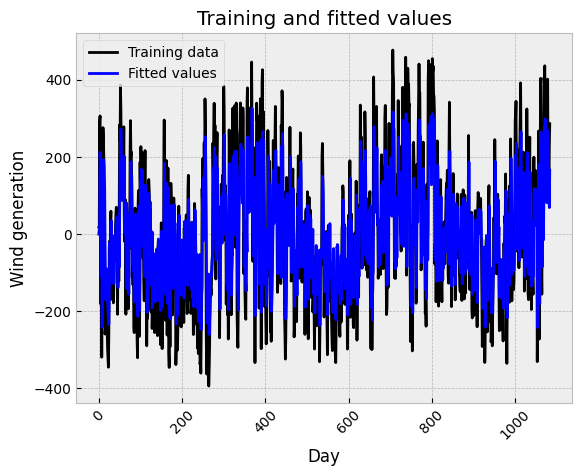

In [10]:
plt.plot(train_data, color = "black",label = 'Training data')
plt.plot(ar3model.fittedvalues, color='blue', label = 'Fitted values')
plt.ylabel('Wind generation')
plt.xlabel('Day')
plt.xticks(rotation=45)
plt.title("Training and fitted values")
plt.legend()
plt.show()

We can say that an auto regressive model of order 3 fits quite well our data, given that it follows nearly perfectly our original series, but for some peaks

In [11]:
import numpy.polynomial.polynomial as poly

np.abs(poly.polyroots((1,0.72,- 0.115,0.072)))

array([1.0780033 , 3.58941527, 3.58941527])

Since each root of the characteristic polynomial is higher than 1 in absolute value, we can state that the fitted process is stationary

An important step is the model diagnostic, applied on the residuals.

We look for normality using qq-plot, Shapiro-wilk and jarque-bera test, histogram, lineplot (residuals vs time), and then the autocorrelation to eventually spot dependence patterns.

**QQ-plot**

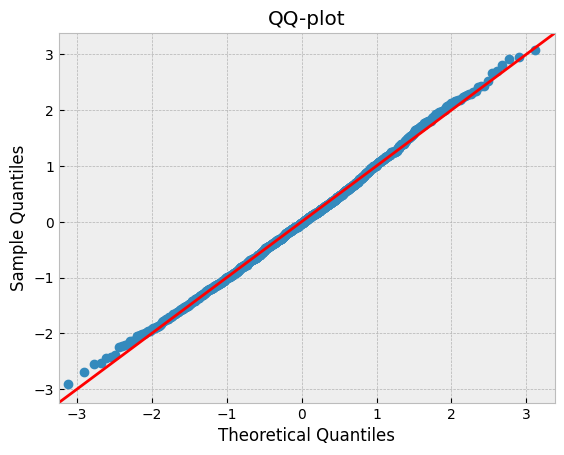

In [12]:
sm.qqplot(ar3model.resid, line="45", fit=True)   # the default comparing distribution is the normal, so we don't need to specify it
                                               # line="45" create the bisector line
                                               # fit=True will scale the plotted data

plt.title("QQ-plot")
plt.show()

**Histogram**

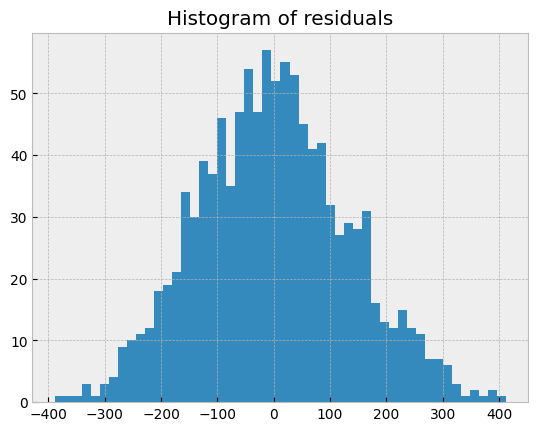

In [13]:
plt.hist(ar3model.resid,bins=50)
plt.title("Histogram of residuals")
plt.show()

**Lineplot (residuals vs time)**

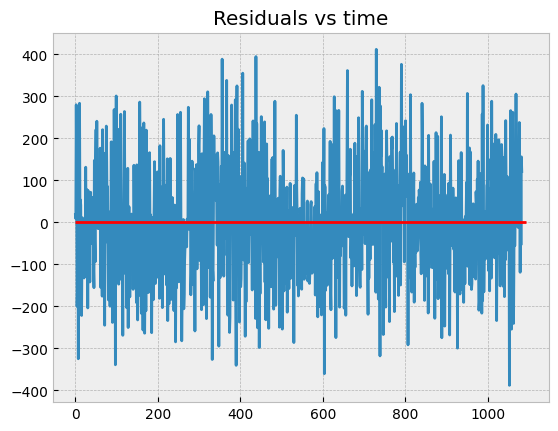

In [14]:
plt.plot(ar3model.resid)
plt.title('Residuals vs time')
plt.hlines(0,0,1094,color="red")
plt.show()

In general, we can be happy with the visual check results

**Shapiro Wilk and Jarque-Bera tests**

In [15]:
shapiro_test = stats.shapiro(ar3model.resid)
shapiro_test

ShapiroResult(statistic=0.9975287914276123, pvalue=0.09937148541212082)

In [16]:
jarque_bera_test = stats.jarque_bera(ar3model.resid)
jarque_bera_test

SignificanceResult(statistic=5.111487754558367, pvalue=0.07763446007140004)

From both the tests, we can see that we fail to reject the null hypothesis of normality, hence our residuals can be said to be normal. We then check the ACF plot to see if our residuals are actually independent:

**Autocorrelation plot**

c:\Users\leona\Desktop\Github_portfolio\git_repo\wind-energy-germany-analysis-and-forecast\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


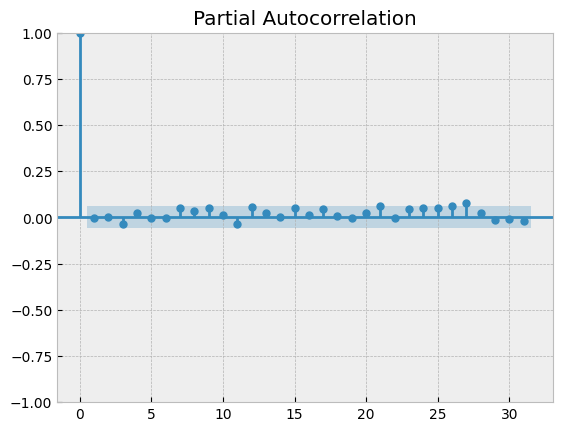

In [17]:
statsmodels.graphics.tsaplots.plot_pacf(ar3model.resid);
plt.show();

There seems to be independence, since all the ticks are between the blue bands

We can measure the fitting performances of the model with the function created before:

In [18]:
print(evaluate_model(ar3model.fittedvalues,train_data))

(133.741, 0.1535)


These results tell us that the models make a squared error that is, in average, 134 (in square root scale). This indicator is not very useful, so we see it in scale compared to the range, and it is 15%

### AR Forecasts

Now let's analyze the model in forecast task. 

The forecast are obtained with a very easy function from statsmodels, and the next plot is very clear to see the results:

In [19]:
preds = ar3model.forecast(10)

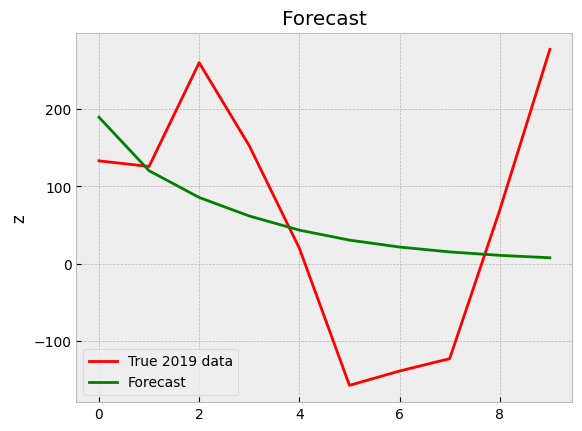

In [22]:
plt.plot(test_data, color = "red",label = 'True 2019 data')
plt.plot(preds, color='green', label = 'Forecast')
plt.ylabel('z')
plt.title("Forecast")
plt.legend()
plt.show()

It is clear that as we go deep in the "future", the model is less able to intercept the pattern followed by the data.

Of course we need to see the evaluation statistics in forecasting:

In [23]:
print(evaluate_model(preds,test_data))

(141.1457, 0.162)


The results are, as foreseeable, worse than training results. But the performance are very similar, and this is a good thing.

# 2. ARX approach

Now we try to take into account the effect of wind capacity and temperature on wind generation. To do so, we need to standardize the two exogeneous variables to make them have mean 0 and variance 1

In [28]:
X = df.loc[:,['wind_capacity','temperature']]

In [35]:
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    [
         ("StandardScaler", numeric_transformer, X.columns)       
    ]
)



In [36]:
X_scal = preprocessor.fit_transform(X)

So now we want a model of this form:

$$Z_t = \phi Z_{t-1} + \beta X_{1,t} + \beta X_{2,t} $$

The above is a very basic case with order 1, but a comparison is necessary to see what order is needed for better performances

As before, we use the last 10 values as test set

In [46]:
z_train = z[:-10]
z_test = z[-10:]

X_train = X_scal[:-10]
X_test = X_scal[-10:]

We can use a for loop to evaluate different orders for the autoregression part of the model and choose the one that minimizes BIC and AIC:

In [56]:
for i in range(1,6):
    print(i)
    arx_test = sm.tsa.statespace.SARIMAX(train_data,
                                  order=(i,0,0),
                                  exog=X_train)
    arx_model_test = arx_test.fit()
    print(f'order {i}: ',end="|| ")
    print('AIC: ',arx_model_test.info_criteria('aic'),end="|| ")
    print('BIC: ',arx_model_test.info_criteria('bic'))

1
order 1: || AIC:  13693.613454321261|| BIC:  13713.567107049259
2
order 2: || AIC:  13683.916115182576|| BIC:  13708.858181092573
3
order 3: || AIC:  13684.649353413872|| BIC:  13714.57983250587
4
order 4: || AIC:  13686.697128022868|| BIC:  13721.616020296866
5
order 5: || AIC:  13687.585183505404|| BIC:  13727.492488961401


Even if the differences are not very high, the best one is the ARX(2) model. We go for it.

In [61]:
arx = sm.tsa.statespace.SARIMAX(train_data,
                                  order=(2,0,0),
                                  exog=X_train)
arx_model = arx.fit()

In [62]:
print(arx_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1084
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -6836.958
Date:                Tue, 21 Mar 2023   AIC                          13683.916
Time:                        09:39:27   BIC                          13708.858
Sample:                             0   HQIC                         13693.359
                               - 1084                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            32.8917      9.622      3.419      0.001      14.034      51.750
x2           -46.4655      9.771     -4.755      0.000     -65.617     -27.314
ar.L1          0.6859      0.033     21.017      0.0

So, as before, we look at:

#### fitted values

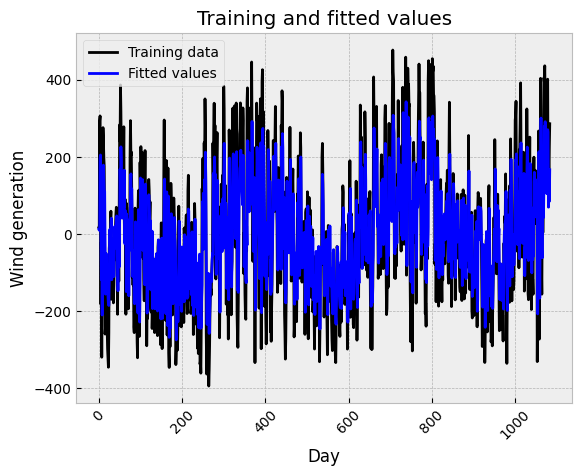

In [63]:
plt.plot(z_train, color = "black",label = 'Training data')
plt.plot(arx_model.fittedvalues, color='blue', label = 'Fitted values')
plt.ylabel('Wind generation')
plt.xlabel('Day')
plt.xticks(rotation=45)
plt.title("Training and fitted values")
plt.legend()
plt.show()

#### residuals distribution

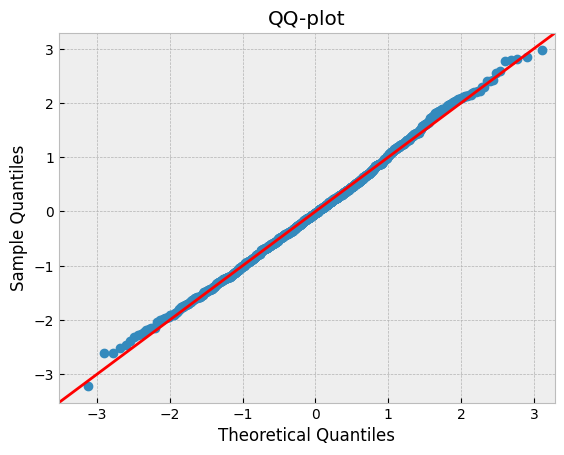

In [64]:
sm.qqplot(arx_model.resid, line="45", fit=True)   # the default comparing distribution is the normal, so we don't need to specify it
                                               # line="45" create the bisector line
                                               # fit=True will scale the plotted data

plt.title("QQ-plot")
plt.show()

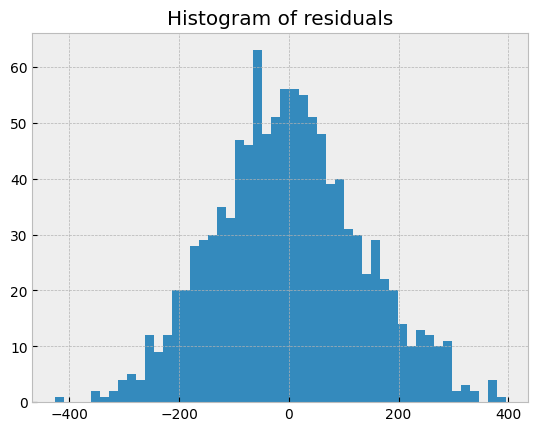

In [65]:
plt.hist(arx_model.resid,bins=50)
plt.title("Histogram of residuals")
plt.show()

In [66]:
shapiro_test = stats.shapiro(arx_model.resid)
shapiro_test

ShapiroResult(statistic=0.9974374175071716, pvalue=0.08451822400093079)

In [67]:
jarque_bera_test = stats.jarque_bera(arx_model.resid)
jarque_bera_test

SignificanceResult(statistic=4.391214431015754, pvalue=0.11129096338482229)

The residual results are very good, even better than the simple autoregression model case

#### forecasting ability

In [69]:
arx_preds = arx_model.forecast(10,exog = X_test)

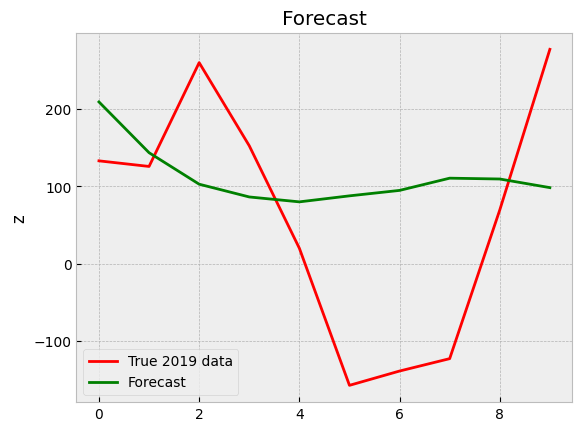

In [70]:
plt.plot(z_test, color = "red",label = 'True 2019 data')
plt.plot(arx_preds, color='green', label = 'Forecast')
plt.ylabel('z')
plt.title("Forecast")
plt.legend()
plt.show()

In [71]:
print(evaluate_model(arx_preds,test_data))

(155.6643, 0.1787)


The metrics about forecasting indicates a better performance for the AR model rather than ARX.

The last step is compare these two approaches looking at AIC and BIC

In [73]:
print('AR AIC: ',ar3model.info_criteria('aic'))
print('AR BIC: ',ar3model.info_criteria('bic'))


print('ARX AIC: ',arx_model.info_criteria('aic'))
print('ARX BIC: ',arx_model.info_criteria('bic'))

AR AIC:  13699.18545451025
AR BIC:  13719.139107238248
ARX AIC:  13683.916115182576
ARX BIC:  13708.858181092573


The AIC suggests AR approach, while the BIC is minimized by the ARX model.